In [19]:
import math
import warnings
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:3f}'.format

# Suppress warnings
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')


# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

y2015.head()

C:\Users\nyejy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.000000,16000.000000,16000.000000,16000.000000,60 months,14.85%,379.390000,C,C5,...,0.000000,2.000000,78.900000,0.000000,0.000000,2.000000,298100.000000,31329.000000,281300.000000,13400.000000
1,68354783,73244544.000000,9600.000000,9600.000000,9600.000000,36 months,7.49%,298.580000,A,A4,...,0.000000,2.000000,100.000000,66.700000,0.000000,0.000000,88635.000000,55387.000000,12500.000000,75635.000000
2,68466916,73356753.000000,25000.000000,25000.000000,25000.000000,36 months,7.49%,777.550000,A,A4,...,0.000000,0.000000,100.000000,20.000000,0.000000,0.000000,373572.000000,68056.000000,38400.000000,82117.000000
3,68466961,73356799.000000,28000.000000,28000.000000,28000.000000,36 months,6.49%,858.050000,A,A2,...,0.000000,0.000000,91.700000,22.200000,0.000000,0.000000,304003.000000,74920.000000,41500.000000,42503.000000
4,68495092,73384866.000000,8650.000000,8650.000000,8650.000000,36 months,19.89%,320.990000,E,E3,...,0.000000,12.000000,100.000000,50.000000,1.000000,0.000000,38998.000000,18926.000000,2750.000000,18248.000000


In [20]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


In [21]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.000000,38982739.000000,13000.000000,13000.000000,13000.000000,60 months,15.990000,316.070000,D,5 years,...,0.000000,3.000000,100.000000,50.000000,1.000000,0.000000,51239.000000,34178.000000,10600.000000,33239.000000
421093,36490806.000000,39222577.000000,12000.000000,12000.000000,12000.000000,60 months,19.990000,317.860000,E,1 year,...,1.000000,2.000000,95.000000,66.700000,0.000000,0.000000,96919.000000,58418.000000,9700.000000,69919.000000
421094,36271262.000000,38982659.000000,20000.000000,20000.000000,20000.000000,36 months,11.990000,664.200000,B,10+ years,...,0.000000,1.000000,100.000000,50.000000,0.000000,1.000000,43740.000000,33307.000000,41700.000000,0.000000
421095,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,NaN,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
421096,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,NaN,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [22]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]
pd.get_dummies(y2015)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_INDIVIDUAL,application_type_JOINT,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,68009401.000000,72868139.000000,16000.000000,16000.000000,16000.000000,14.850000,379.390000,48000.000000,33.180000,0.000000,...,0,0,0,0,0,1,0,0,0,0
1,68354783.000000,73244544.000000,9600.000000,9600.000000,9600.000000,7.490000,298.580000,60000.000000,22.440000,0.000000,...,0,0,0,0,0,1,0,0,0,0
2,68466916.000000,73356753.000000,25000.000000,25000.000000,25000.000000,7.490000,777.550000,109000.000000,26.020000,0.000000,...,0,0,0,0,0,1,0,0,0,0
3,68466961.000000,73356799.000000,28000.000000,28000.000000,28000.000000,6.490000,858.050000,92000.000000,21.600000,0.000000,...,0,0,0,0,0,1,0,0,0,0
4,68495092.000000,73384866.000000,8650.000000,8650.000000,8650.000000,19.890000,320.990000,55000.000000,25.490000,0.000000,...,0,0,0,0,0,1,0,0,0,0
5,68506798.000000,73396623.000000,23000.000000,23000.000000,23000.000000,8.490000,471.770000,64000.000000,18.280000,0.000000,...,0,0,0,0,0,1,0,0,0,0
6,68566886.000000,73456723.000000,29900.000000,29900.000000,29900.000000,12.880000,678.490000,65000.000000,21.770000,0.000000,...,0,0,0,0,0,1,0,0,0,0
7,68577849.000000,73467703.000000,18000.000000,18000.000000,18000.000000,11.990000,400.310000,112000.000000,8.680000,0.000000,...,0,0,0,0,0,1,0,0,0,0
8,66310712.000000,71035433.000000,35000.000000,35000.000000,35000.000000,14.850000,829.900000,110000.000000,17.060000,0.000000,...,0,0,0,0,0,1,0,0,0,0
9,68476807.000000,73366655.000000,10400.000000,10400.000000,10400.000000,22.450000,289.910000,104433.000000,25.370000,1.000000,...,0,0,0,0,0,1,0,0,0,0


In [23]:
# Applying the Random Forest 
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.97986274, 0.98057515, 0.98171499, 0.98173874, 0.96957967,
       0.97888863, 0.963357  , 0.98064547, 0.98038331, 0.98097658])

# Third Attempt
Drop as much data as possible without going below an average of 90% accuracy in a 10-fold validation.  Use PCA to reduce the data.

In [24]:
# X is the scalar of the df data.  Standardize features by removing the mean and scaling to unit variance.
# Dataset might behave badly if the individual feature do no look like standard distributed data.

# Prepare the X and Y variable, where Y is dataframe column.
# fit_transform fits the model with X and apply dimensionality reduction on X.
pca = PCA(0.90)
pca.fit(X)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())
print(pca.singular_values_)

[1.92237416e+14]
[0.99842296]
[0.99842296]
[8.99722305e+09]


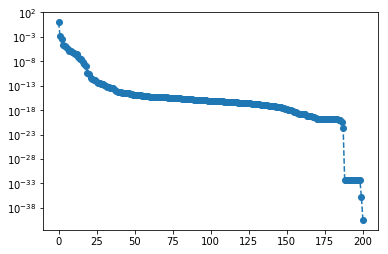

In [25]:
# Y axis says how much can be explained, where 9th variable has very small impact on predicting Property.
pca = PCA().fit(X)

plt.semilogy(pca.explained_variance_ratio_, '--o')
plt.show()

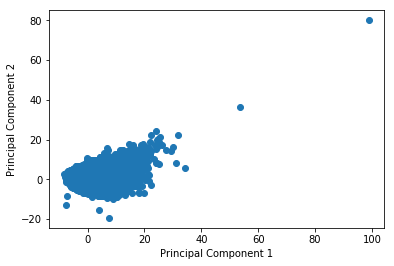

(421095, 201)
(421095, 131)
[[ 3.86706499  2.67151796 -3.08165862 ...  0.08123569  0.42293127
   0.12269769]
 [-3.27656232  0.16845513 -2.27250735 ... -0.05411601  0.14219844
  -0.05030381]
 [ 2.56234641 -4.14952233  1.67144531 ... -0.99985926  1.21028666
  -0.12184338]
 ...
 [-1.77622697 -0.62691096  3.59449708 ... -0.86317636  1.1843222
  -0.2553021 ]
 [-0.42181367  0.73707247  4.78679502 ...  1.02941911  0.65365533
  -0.16303162]
 [ 0.05600907 -1.48311595 -0.05713794 ... -0.0831609   0.03918796
  -0.04344942]]


In [26]:
# Which variables/how many variables to keep
from sklearn.preprocessing import StandardScaler

# Each of 9 variables (out of 10) have different ranges.
# Standard Scalar makes it so all these different ranges makes sense.
# Standard = each number in the ranges are subtracted by the mean, and divided by standard deviation squared.
# Standard Scalar = same thing, but now the range is 0 to 1. Make everything comparable.
# Some examples are tests, intelligence levels, etc. Trying to standardize everyone.
X_std = StandardScaler().fit_transform(X)

# Pick the smallest number of Principal Components that explain 95% of the variables.
# That number is = to number of variables you should choose.
sklearn_pca = PCA(0.95)
Y_sklearn = sklearn_pca.fit_transform(X_std)

plt.scatter(Y_sklearn[:,0], Y_sklearn[:,3])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Each of the column is equal to the principal component.
# 5136 rows, 23 columns.
# 5136 rows, 8 columns.
print(X_std.shape)
print(Y_sklearn.shape)
print(Y_sklearn)

# Apply Data Splitting
The data is simply too big, cut down most of it.

In [27]:
## Holdout Groups is commonly starting at 30% of data, but 1% to 50% is okay.
data = X
target = Y
#print(data.shape)
#print(target.shape)
#print(data)
#print(target)

# Test your model with different holdout groups.
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=40)

print(X_train.size)
print(X_test.size)
print(y_train.size)
print(y_test.size)

76175985
8464110
378985
42110


In [28]:
# Applying the Random Forest 
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
#X = y2015.drop('loan_status', 1)
#Y = y2015['loan_status']
#X = pd.get_dummies(X)
#X = X.dropna(axis=1)

cross_val_score(rfc, X_train, y_train, cv=10)

array([0.98084534, 0.9815577 , 0.98139842, 0.98055358, 0.98113357,
       0.98152937, 0.9810808 , 0.98113257, 0.9810798 , 0.98121174])